# `sdswrapper` tutorial

### A Python package for spatial data science workflows.

To install use: 
```bash
!pip install sdswrapper
```

Python packages:

In [1]:
import time
import rasterio
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor 

from pykrige.rk import RegressionKriging
from pykrige.ok import OrdinaryKriging

import sdswrapper as sds

Models instantiation:

In [2]:
model_list = [
    ('LinearRegression', LinearRegression()),
    ('RidgeRegression', Ridge()),
    ('LassoRegression', Lasso()),
    ('ElasticNetRegression', ElasticNet()),
    ('DecisionTreeRegression', DecisionTreeRegressor()),
    ('RandomForestRegression', RandomForestRegressor()),
    ('GradientBoostingRegression', GradientBoostingRegressor()),
    ('SupportVectorRegression', SVR()),
    ('KNearestNeighborsRegression', KNeighborsRegressor())
]

In [3]:
krige_models = list()

for model_name, model in model_list:

    if model_name == 'DecisionTreeRegression':

        continue

    krige_models.append(
        (
            'KrigingRegressionRF' + model_name,
            RegressionKriging(
                regression_model    = model,
                variogram_model     = 'linear',
                verbose             = False,
                nlags               = 10
            )
        )
    )

In [4]:
ordinary_kriging = sds.OrdinaryKrigingInterface()


model_list.append(
    ('OrdinaryKriging', ordinary_kriging)
)

In [5]:
model_list.extend(krige_models)

In [6]:
model_list

[('LinearRegression', LinearRegression()),
 ('RidgeRegression', Ridge()),
 ('LassoRegression', Lasso()),
 ('ElasticNetRegression', ElasticNet()),
 ('DecisionTreeRegression', DecisionTreeRegressor()),
 ('RandomForestRegression', RandomForestRegressor()),
 ('GradientBoostingRegression', GradientBoostingRegressor()),
 ('SupportVectorRegression', SVR()),
 ('KNearestNeighborsRegression', KNeighborsRegressor()),
 ('OrdinaryKriging', OrdinaryKrigingInterface()),
 ('KrigingRegressionRFLinearRegression',
  <pykrige.rk.RegressionKriging at 0x163853c50>),
 ('KrigingRegressionRFRidgeRegression',
  <pykrige.rk.RegressionKriging at 0x16190b9d0>),
 ('KrigingRegressionRFLassoRegression',
  <pykrige.rk.RegressionKriging at 0x15458c150>),
 ('KrigingRegressionRFElasticNetRegression',
  <pykrige.rk.RegressionKriging at 0x16191dd90>),
 ('KrigingRegressionRFRandomForestRegression',
  <pykrige.rk.RegressionKriging at 0x147fe1450>),
 ('KrigingRegressionRFGradientBoostingRegression',
  <pykrige.rk.RegressionKr

Study area polygon:

In [7]:
with rasterio.open(sds.EXAMPLE_PROBABILITY_SURFACE_FILEPATH) as src:

    reference_polygon_example = sds.SampleGenerator.get_polygon(src)

In [8]:
reference_polygon_example

[{'type': 'Polygon',
  'coordinates': [[(-81.57551, -57.133855000000004),
    (-81.57551, 12.991148657719998),
    (-34.03384085356, 12.991148657719998),
    (-34.03384085356, -57.133855000000004),
    (-81.57551, -57.133855000000004)]]}]

Sample Generator instantiation (for running the examples, here):

In [9]:
sg = sds.SampleGenerator(
    sample_file         = sds.EXAMPLE_SAMPLE_FILEPATH,
    features            = sds.EXAMPLE_FEATURES_FILEPATH,
    probability_surface = sds.EXAMPLE_PROBABILITY_SURFACE_FILEPATH,
    reference_polygon   = reference_polygon_example
)

Simulating presence sites sampling:

In [10]:
df_presence = sg.sample(100)
df_pseudoabsences = sg.sample(50, pseudoabsences=True)

Simulating (pseudo)absences sites sampling:

In [11]:
df_presence['occ'] = 1
df_pseudoabsences['occ'] = 0

Presence + (pseudo)absences dataset:

In [12]:
dataset = pd.concat([df_presence, df_pseudoabsences], axis=0)

Visual checking:

In [13]:
plt.imshow(sg.probability_surface, cmap='plasma')

plt.scatter(
    df_presence['lon'], 
    df_presence['lat'],
    color = 'blue',
    alpha = 0.5, 
    label = 'Presence sites'
)

plt.scatter(
    df_pseudoabsences['lon'], 
    df_pseudoabsences['lat'],
    color = 'red',
    alpha = 0.5,
    label = 'Pseuabsence sites'
)

plt.title('Sample dataset')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.legend(bbox_to_anchor=(1., 1.), loc='upper left')

(A very) Simple simulation of abundance:

In [14]:
plt.imshow(
    np.where(sg.features[0]['raster'][:1683,:1141] < 0, np.nan, sg.probability_surface),
    cmap='plasma'
)

plt.scatter(300, 300, color='red', alpha=0.9, s=80, marker='.', label='Perffect match')
plt.scatter(700, 950, color='red', alpha=0.9, s=80, marker='+', label='Mismatch')
plt.legend(bbox_to_anchor=(1.3, 1.), loc='upper left')
plt.colorbar(label='Abundance')

In [15]:
def gaussian_function(df, mu1=300., sigma1=500., mu2=300., sigma2=500., mu3=25., sigma3=2, mu4=2000., sigma4=500.):
    """
    Calcula uma função gaussiana combinando as colunas:

    - lon:  x1, mu1, sigma1
    - lat:  x2, mu2, sigma2
    - 'wc2.1_2.5m_bio_1': x3, mu3, sigma3
    - 'wc2.1_2.5m_bio_12: x4, mu4, sigma4

    Os parâmetros mu[1:3], sigma[1:4] podem ser ajustados conforme necessário.
    """
    x1 = df['lon']
    x2 = df['lat']
    x3 = df['wc2.1_2.5m_bio_1']
    x4 = df['wc2.1_2.5m_bio_12']

    gauss1 = np.exp(-0.5 * ((x1 - mu1) / sigma1) ** 2)

    gauss2 = np.exp(-0.5 * ((x2 - mu2) / sigma2) ** 2)

    gauss3 = np.exp(-0.5 * ((x3 - mu3) / sigma3) ** 2)

    gauss4 = np.exp(-0.5 * ((x4 - mu4) / sigma4) ** 2)

    return gauss1 * gauss2 * gauss3 * gauss4


K = 1000 # carryng capacity

dataset['abundance'] = np.round(gaussian_function(dataset) * K, 1)

Some adjustings, preventing overflow errors (potentially comming from .tif files):

In [16]:
# tratando os valores excessivamente baixos no .tiff (pois costuma levar a overflow).

dataset = dataset.map(
    lambda x: -999.0 if x < -1.0 else x
)

In [17]:
dataset['wc2.1_2.5m_bio_1'] = dataset['wc2.1_2.5m_bio_1'].round(1)
dataset['wc2.1_2.5m_bio_12'] = dataset['wc2.1_2.5m_bio_12'].round(1)

Final dataset inspection:

In [18]:
dataset

lat    lon  wc2.1_2.5m_bio_1  wc2.1_2.5m_bio_12  occ  abundance
0    383.0   93.0              25.9             2618.0    1      377.6
1    565.0  786.0              24.6             1659.0    1      421.6
2    500.0  403.0              26.1             2414.0    1      551.4
3   1309.0  217.0               6.8             2056.0    1        0.0
4    122.0  498.0              25.9             1828.0    1      745.9
..     ...    ...               ...                ...  ...        ...
45   653.0  852.0              23.0             1334.0    0      107.3
46  1457.0  291.0               8.9              204.0    0        0.0
47    82.0  342.0              26.5             1168.0    0      168.3
48   962.0  309.0            -999.0              145.0    0        0.0
49   728.0  849.0              23.3             1296.0    0       99.4

[150 rows x 6 columns]

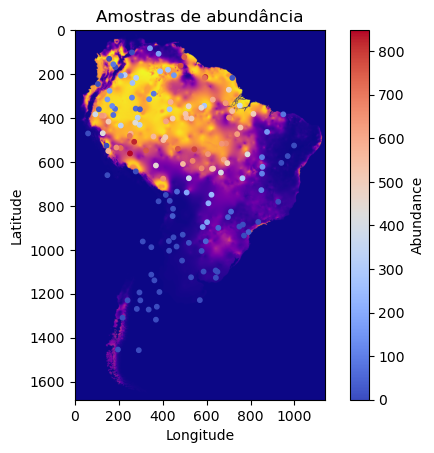

In [19]:
plt.imshow(sg.probability_surface, cmap='plasma')

plt.scatter(
    dataset['lon'],
    dataset['lat'],
    c = dataset['abundance'],
    cmap = 'coolwarm',
    s = 10
)

plt.colorbar(label='Abundance')

plt.title('Amostras de abundância')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Spatial DS Wrapper - fitting all the models from `model_list`:

In [20]:
sds_wrapper = sds.Wrapper(
    model_list              = model_list,
    dataset                 = dataset,
    X_column_names          = ['lat', 'lon'],
    P_column_names          = ['wc2.1_2.5m_bio_1', 'wc2.1_2.5m_bio_12'],
    y_column_name           = 'abundance',
    projections_folder      = '/', # path to a folder dedicated to saving the projections
    k                       = 5,
    gridsearch_parameters   = None
)

In [21]:
output = sds_wrapper.fit()

Inspecting outputs:

In [22]:
df_output = pd.DataFrame(output).sort_values(by='model_metrics_mean', ascending=True)

In [23]:
df_output

sample_size                                            name model_type  \
15          150   KrigingRegressionRFGradientBoostingRegression         KR   
6           150                      GradientBoostingRegression         SK   
5           150                          RandomForestRegression         SK   
14          150       KrigingRegressionRFRandomForestRegression         KR   
4           150                          DecisionTreeRegression         SK   
8           150                     KNearestNeighborsRegression         SK   
17          150  KrigingRegressionRFKNearestNeighborsRegression         KR   
16          150      KrigingRegressionRFSupportVectorRegression         KR   
9           150                                 OrdinaryKriging         KR   
7           150                         SupportVectorRegression         SK   
3           150                            ElasticNetRegression         SK   
13          150         KrigingRegressionRFElasticNetRegression         KR   
12          150              KrigingRegressionRFLassoRegression         KR   
11          150              KrigingRegressionRFRidgeRegression         KR   
10          150             KrigingRegressionRFLinearRegression         KR   
1           150                                 RidgeRegression         SK   
2           150                                 LassoRegression         SK   
0           150                                LinearRegression         SK   

    model_metrics_mean  model_metrics_std  \
15           89.258107          68.490965   
6            89.339250          67.666467   
5            93.252904          67.555102   
14           97.085933          69.978581   
4           105.537628          99.737331   
8           124.618890          48.414915   
17          166.516654          47.513247   
16          190.515175          92.466154   
9           268.445566          35.016483   
7           318.352562          82.818742   
3           811.828045        1043.747188   
13         1188.907787        1949.036854   
12         1214.771950        2000.703709   
11         1216.058735        2003.272657   
10         1216.544311        2004.242633   
1          1262.479941        1932.056499   
2          1263.835194        1934.178658   
0          1279.026321        1964.488947   

                                        trained_model  
15  <pykrige.rk.RegressionKriging object at 0x1638...  
6   ([DecisionTreeRegressor(criterion='friedman_ms...  
5   (DecisionTreeRegressor(max_features=1.0, rando...  
14  <pykrige.rk.RegressionKriging object at 0x147f...  
4                             DecisionTreeRegressor()  
8                               KNeighborsRegressor()  
17  <pykrige.rk.RegressionKriging object at 0x1638...  
16  <pykrige.rk.RegressionKriging object at 0x1638...  
9                          OrdinaryKrigingInterface()  
7                                               SVR()  
3                                        ElasticNet()  
13  <pykrige.rk.RegressionKriging object at 0x1619...  
12  <pykrige.rk.RegressionKriging object at 0x1545...  
11  <pykrige.rk.RegressionKriging object at 0x1619...  
10  <pykrige.rk.RegressionKriging object at 0x1638...  
1                                             Ridge()  
2                                             Lasso()  
0                                  LinearRegression()

`get_full_data`, from `SampleGenerator` class, is a helper to extract whole spatial data layer in a `pandas` `DataFrame` data structure.

In [25]:
df_full_data = sg.get_full_data()

In [26]:
df_full_data = df_full_data.map(
    lambda x: -999.0 if x < -1.0 else x
)

df_full_data['wc2.1_2.5m_bio_1'] = df_full_data['wc2.1_2.5m_bio_1'].round(1)
df_full_data['wc2.1_2.5m_bio_12'] = df_full_data['wc2.1_2.5m_bio_12'].round(1)

In [27]:
df_full_data

lon   lat  wc2.1_2.5m_bio_1  wc2.1_2.5m_bio_12
0           0     0            -999.0             -999.0
1           1     0            -999.0             -999.0
2           2     0            -999.0             -999.0
3           3     0            -999.0             -999.0
4           4     0            -999.0             -999.0
...       ...   ...               ...                ...
1923123  1137  1683            -999.0             -999.0
1923124  1138  1683            -999.0             -999.0
1923125  1139  1683            -999.0             -999.0
1923126  1140  1683            -999.0             -999.0
1923127  1141  1683            -999.0             -999.0

[1923128 rows x 4 columns]

Choosing a model (`model_id`) from the outputs (`df_output`) and computing model predictions:

In [44]:
model_id = 6

print('Model:', output[model_id]['name'])

prediction = sds_wrapper.predict(
    trained_model   = output[model_id]['trained_model'],
    X               = df_full_data[['lon', 'lat']],
    p               = df_full_data[['wc2.1_2.5m_bio_1', 'wc2.1_2.5m_bio_12']],
    shape           = sg.features[0]['raster'].shape
)

Model: GradientBoostingRegression


"Manually" plotting output:

In [45]:
plt.imshow(
    np.where(sg.features[0]['raster'] < 0, np.nan, prediction),
    cmap='plasma'
)

plt.colorbar()

Computing model prediction scores, given an ground truth (given by the user):

*Simulation of the ground truth:*

In [46]:
ground_truth = np.round(gaussian_function(df_full_data) * K, 1)

In [47]:
ground_truth_raster = ground_truth.values.reshape(sg.features[0]['raster'].shape)

In [48]:
ground_truth_raster = np.where(sg.features[0]['raster'] < 0, np.nan, ground_truth_raster)

In [49]:
plt.imshow(
    ground_truth_raster,
    cmap='plasma'
)

plt.colorbar()

*Scoring model prediction vs. ground truth:*

In [50]:
# RMSE #
sds_wrapper.score(
    prediction = np.where(np.isnan(prediction), -1, prediction),
    reference_data = np.where(np.isnan(ground_truth_raster), -1, ground_truth_raster)
)

52.226996385950045

Visual inspection:

In [51]:
prediction_clean = np.where(sg.features[0]['raster'] < 0, np.nan, prediction)

In [53]:
fig = plt.figure(figsize=(15, 5))

# Plotando o mapa observado
ax1 = plt.subplot(1, 2, 1)
plt.imshow(ground_truth_raster, cmap='plasma', vmin=0, vmax=1000)
plt.colorbar()
plt.title('Observed', fontsize=16)

# Adicionando os pontos do dataset
plt.scatter(dataset['lon'], dataset['lat'], 
            c='red', s=10, label='Dataset Points')
plt.legend()

# Plotando o mapa previsto
ax2 = plt.subplot(1, 2, 2)
plt.imshow(prediction_clean, origin='lower', cmap='plasma', vmin=0, vmax=1000)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title('Predicted', fontsize=16)

# Adicionando os pontos do dataset
plt.scatter(dataset['lon'], dataset['lat'], 
            c='red', s=10, label='Dataset Points')
plt.legend()

plt.tight_layout()

Text(0.5, 1.0, 'Error in predicted values')

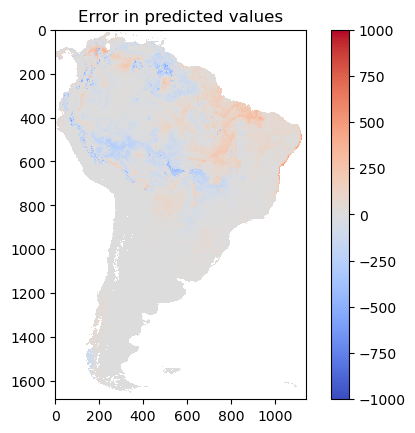

In [54]:
gap = prediction - ground_truth_raster

gap_clean = np.where(sg.features[0]['raster'] < 0, np.nan, gap)


plt.imshow(gap_clean, cmap='coolwarm', interpolation='nearest', vmin=-1000, vmax=1000)
plt.colorbar()
plt.title('Error in predicted values')

Wrapper plot pipeline ("non manually" solution):

In [40]:
# Computing predictions for all models in the output DataFrame (optional step)
df_output['prediction']  = df_output['trained_model'].apply(lambda x: sds_wrapper.predict(
    trained_model = x,
    X = df_full_data[['lon', 'lat']],
    p = df_full_data[['wc2.1_2.5m_bio_1', 'wc2.1_2.5m_bio_12']],
    shape = sg.features[0]['raster'].shape
))

In [55]:
# Masking predictions with the raster mask (optional step for whole datasets, but also relevant for single predictions)
my_nan_mask = np.where(
    sg.features[0]['raster'] < 0, 
    np.nan, 
    sg.features[0]['raster']
).reshape(sg.features[0]['raster'].shape)


df_output['prediction']  = df_output['prediction'].apply(lambda x: sds_wrapper.mask(
    prediction = x, 
    nan_mask = my_nan_mask
))

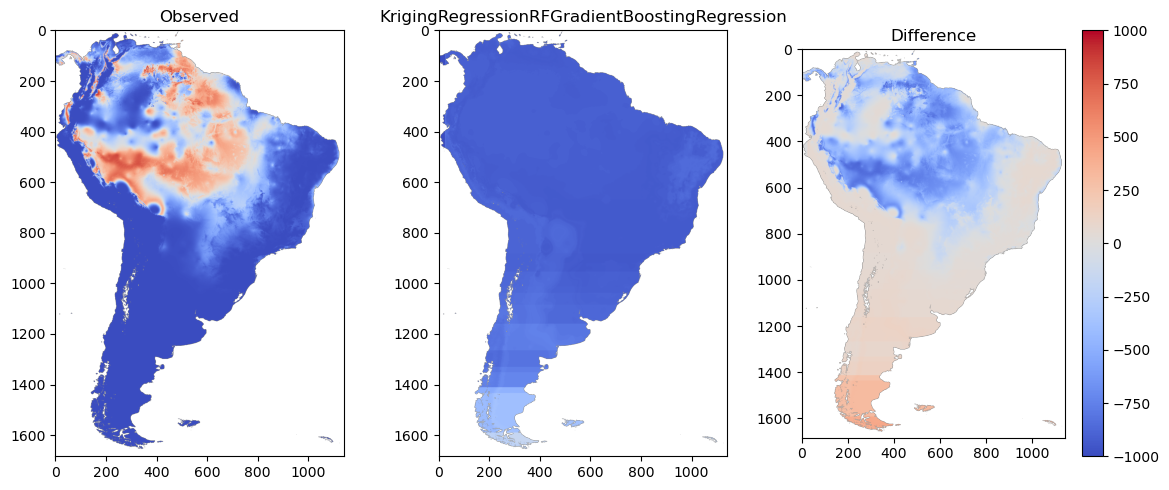

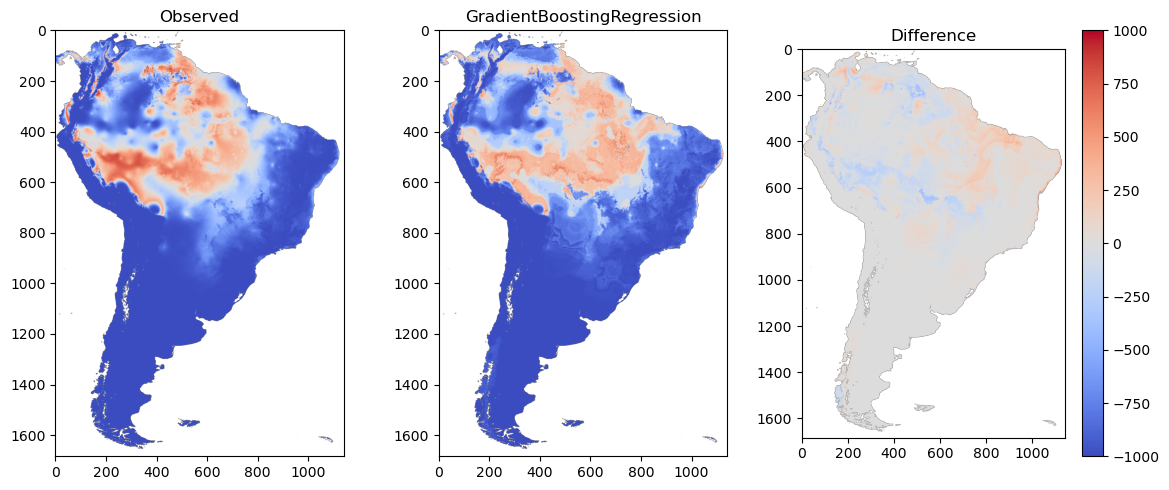

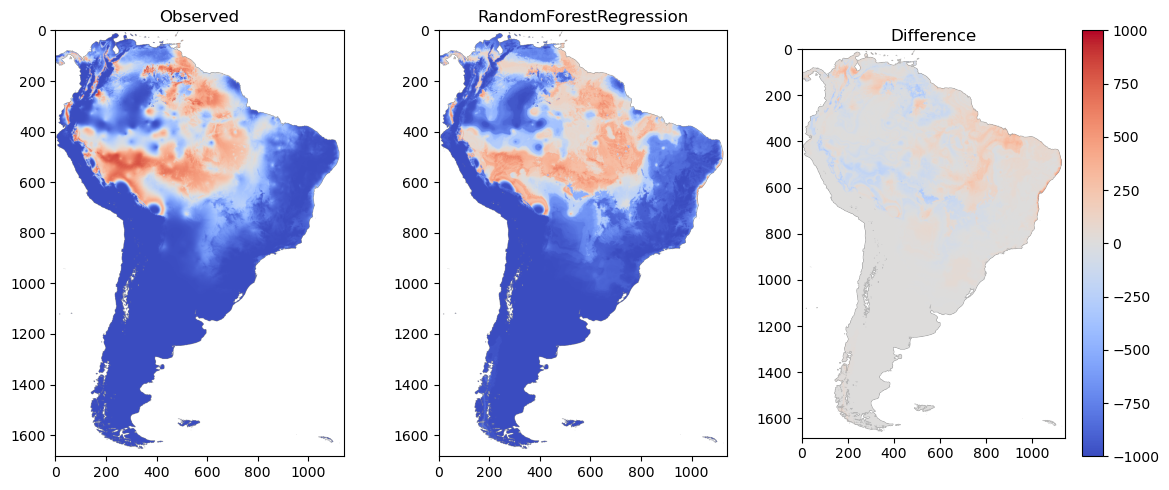

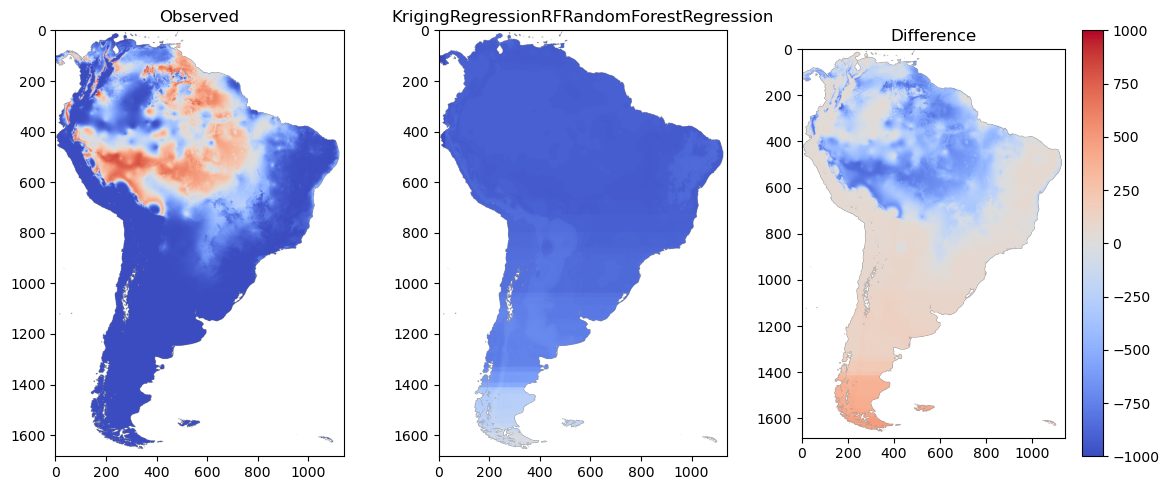

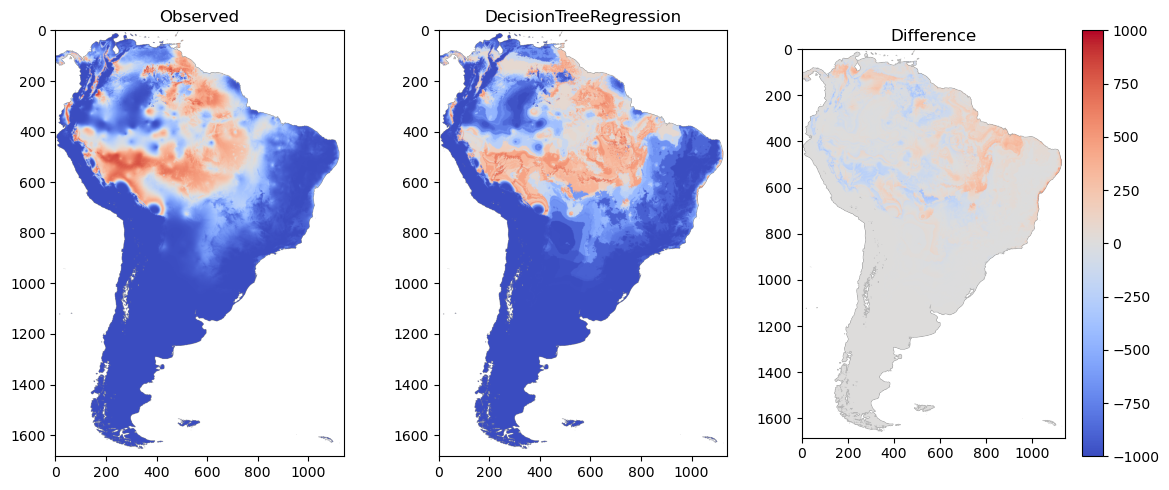

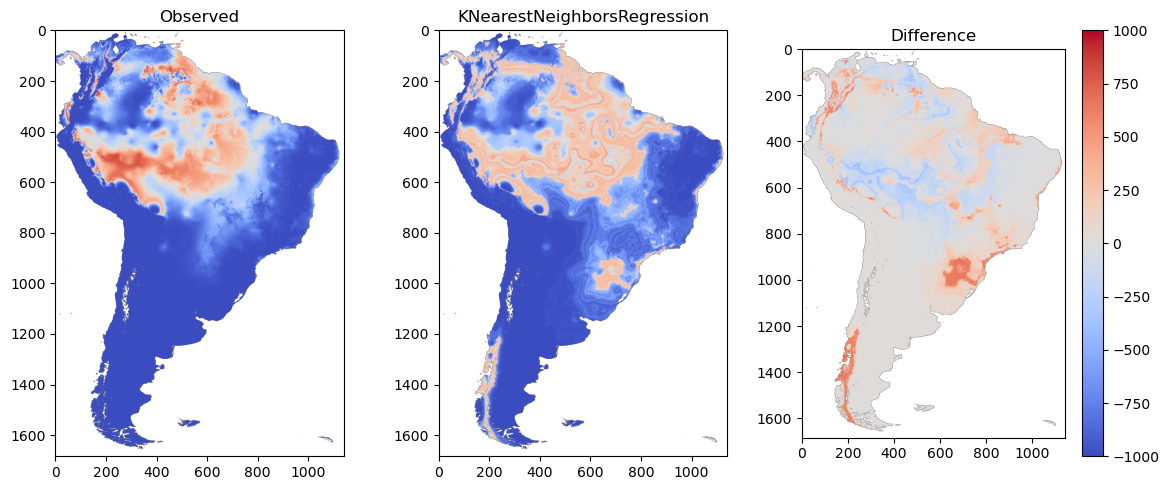

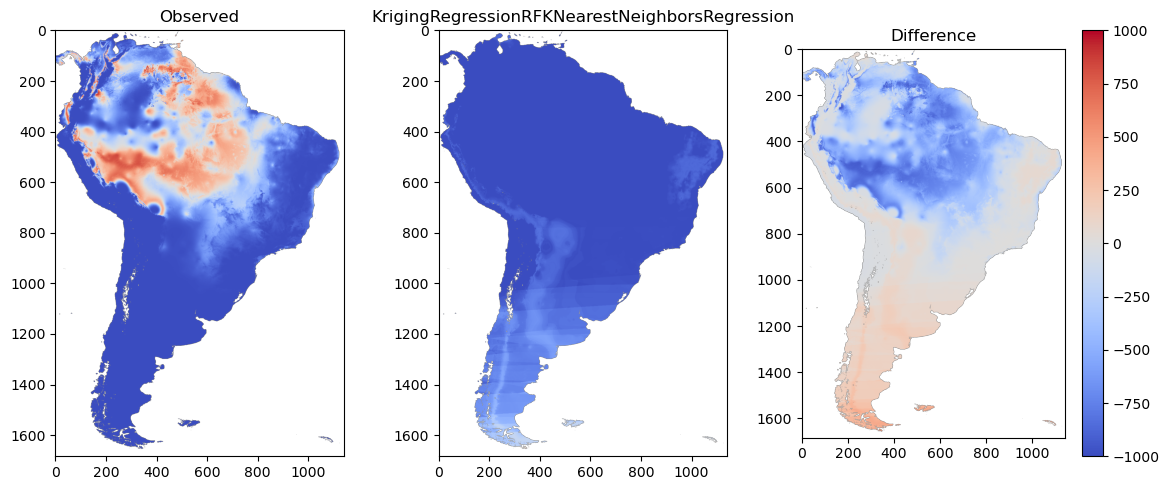

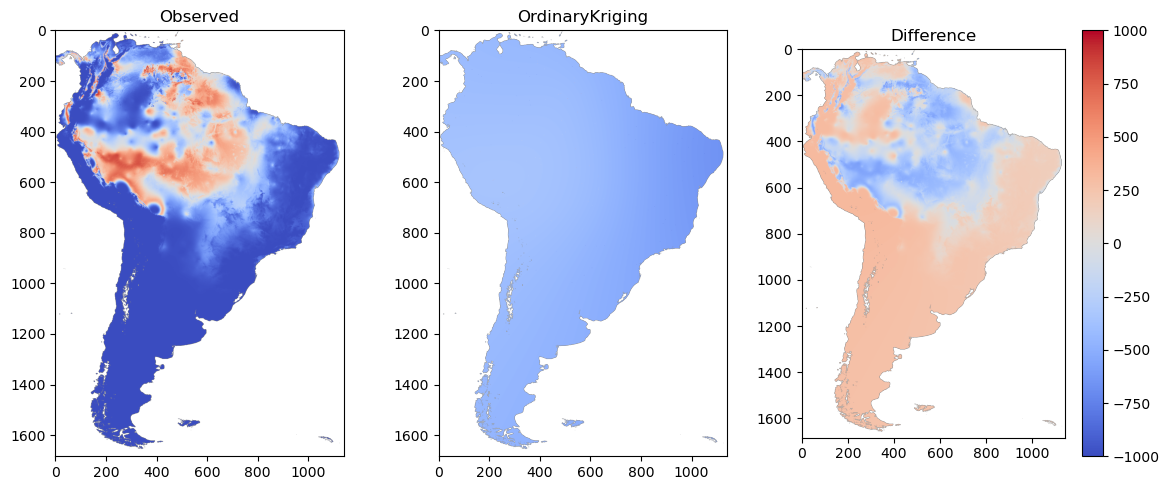

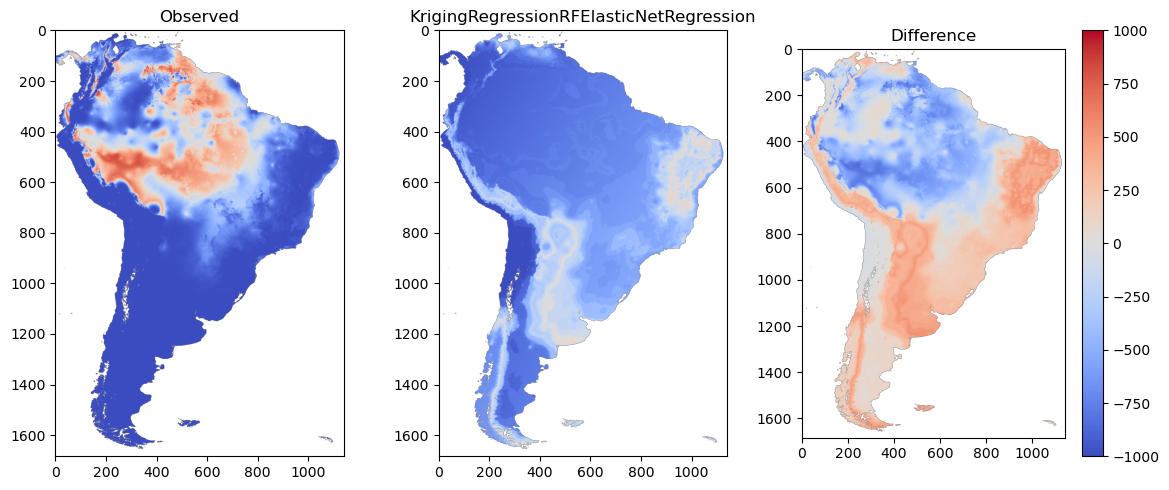

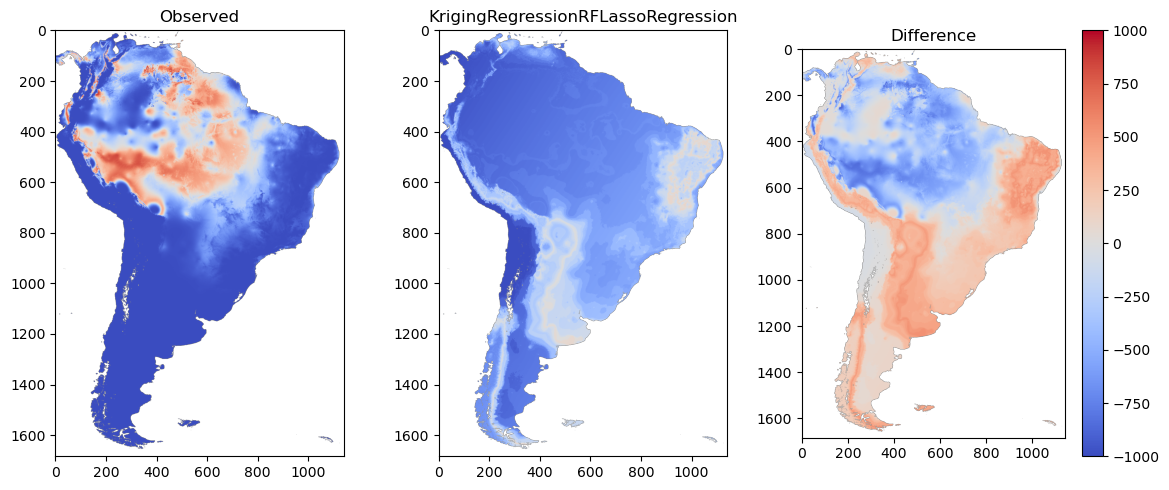

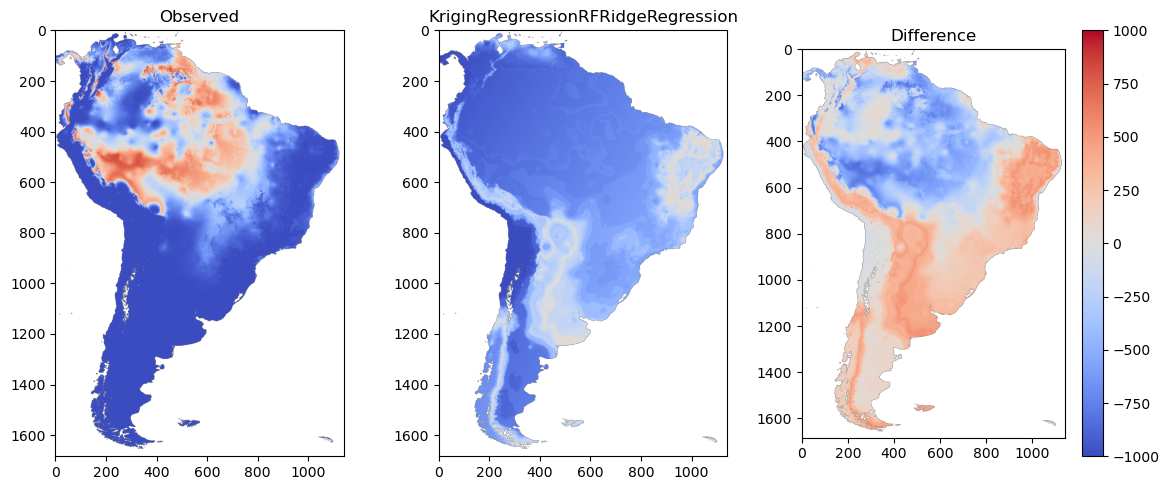

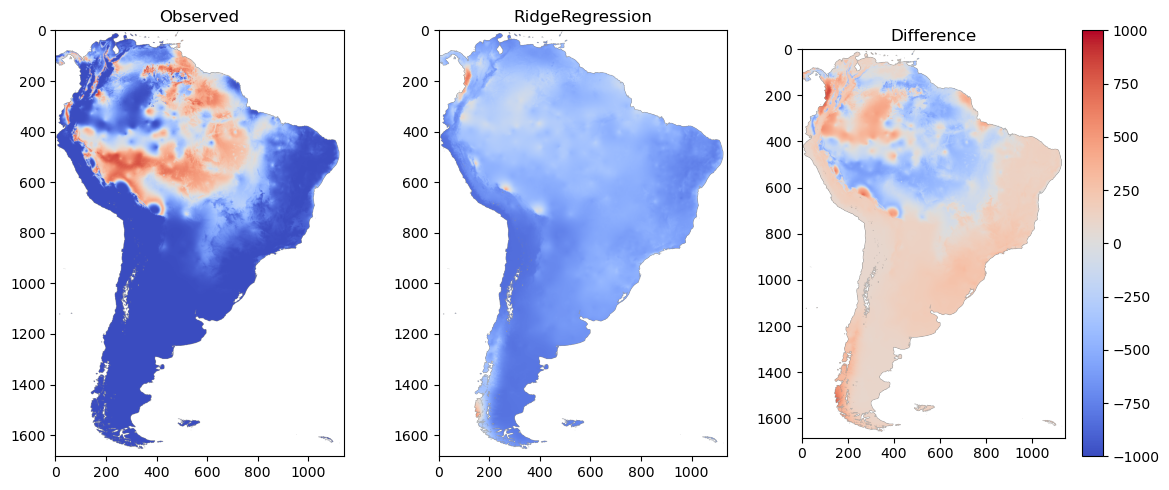

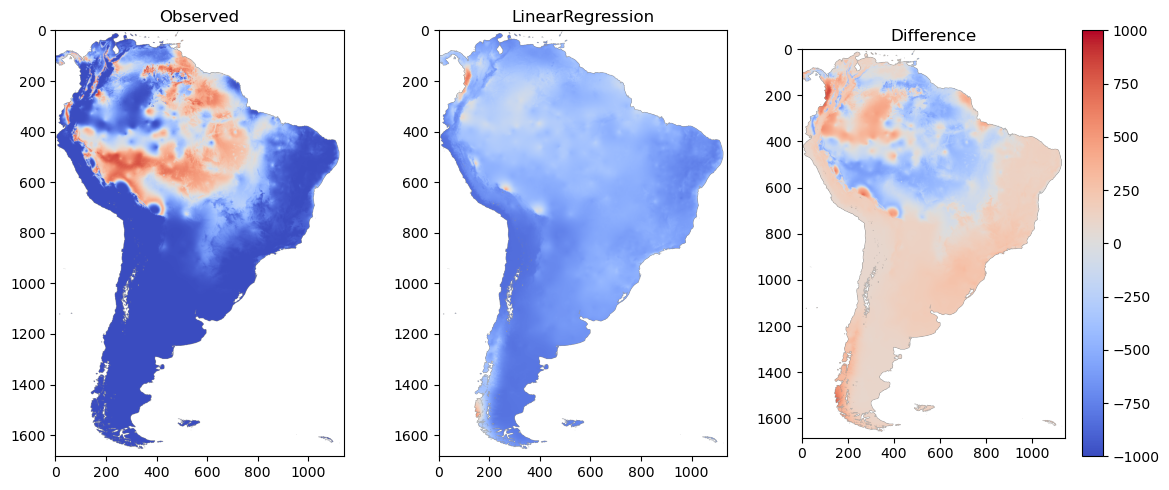

In [57]:
sds_wrapper.plot(
    df_output, 
    reference_data = ground_truth_raster, 
    best = False
)

In [43]:
# End #